In [25]:
from owid.catalog import Dataset
from etl.paths import DATA_DIR
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from etl.data_helpers import geo


ds_wb = Dataset(
    DATA_DIR
    / "garden"
    / "wb"
    / "2023-12-29"
    / "gender_statistics"
)

ds_income_groups = Dataset(
    DATA_DIR
    / "garden"
    / "wb"
    / "2024-03-11"
    / "income_groups"
)

ds_regions= Dataset(
    DATA_DIR
    / "garden"
    / "regions"
    / "2023-01-01"
    / "regions"
)

ds_population = Dataset(
    DATA_DIR
    / "garden"
    / "demography"
    / "2023-03-31"
    / "population"
)
ds_who = Dataset(
    DATA_DIR
    / "garden"
    / "who"
    / "2023-08-01"
    / "mortality_database"
)


tb = ds_wb["gender_statistics"].reset_index()
tb_population = ds_population["population"].reset_index()
tb_data = tb[["country", "year", "se_prm_uner"]]

tb_both = ds_who["neuropsychiatric_conditions__both_sexes__all_ages"].reset_index()
tb_females = ds_who["neuropsychiatric_conditions__females__all_ages"].reset_index()
tb_males = ds_who["neuropsychiatric_conditions__males__all_ages"].reset_index()

tb_data = tb_males.filter(items=['country', 'year'] + [col for col in tb_males if col.startswith('deaths_from_neuropsychiatric_conditions_per_100_000_people')])
years_with_data = tb_data.dropna(subset=['deaths_from_neuropsychiatric_conditions_per_100_000_people_in__males_aged_all_ages'])['year'].unique()

#years_with_data = tb_data.dropna(subset=['se_prm_uner'])['year'].unique()
tb_data = tb_data[tb_data['year'].isin(years_with_data)]

# Regions aggregates to create.
REGIONS = {
    # Default continents.
    "Africa",
    "Asia",
    "Europe",
    "North America",
    "Oceania",
    "South America"}

# Assuming that list_members_of_region returns a list of countries for a given region
country_to_region = {}
for region in REGIONS:
    countries = geo.list_members_of_region(region=region, ds_regions=ds_regions, ds_income_groups=ds_income_groups)
    for country in countries:
        country_to_region[country] = region
tb_data['region'] = tb_data['country'].map(country_to_region)

INCOME_GROUPS = {# Income groups.
    "Low-income countries",
    "Upper-middle-income countries",
    "Lower-middle-income countries",
    "High-income countries"}
# Assuming that list_members_of_region returns a list of countries for a given region
country_to_income = {}
for region in INCOME_GROUPS:
    countries = geo.list_members_of_region(region=region, ds_regions=ds_regions, ds_income_groups=ds_income_groups)
    for country in countries:
        country_to_income[country] = region

# Create the new column
tb_data['income_group'] = tb_data['country'].map(country_to_income)
tb_merged = pd.merge(tb_data, tb_population, on=["country", "year"])
tb_merged = tb_merged.drop(columns = "source")

KeyError: ['neuropsychiatric_conditions__males__all_ages']

In [306]:

# Clean data to include only years with data.
years_with_data = tb_data.dropna(subset=["se_prm_uner"])["year"].unique()
tb_data = tb_data[tb_data["year"].isin(years_with_data)]

# Map countries to their regions and income groups.
country_to_region = {
    country: region for region in REGIONS for country in geo.list_members_of_region(region, ds_regions)
}
tb_data["region"] = tb_data["country"].map(country_to_region)

country_to_income_group = {
    country: income_group
    for income_group in INCOME_GROUPS
    for country in geo.list_members_of_region(income_group, ds_regions, ds_income_groups)
}
tb_data["income_group"] = tb_data["country"].map(country_to_income_group)

# Get all unique countries and years
all_countries = set(country_to_region.keys()).union(set(country_to_income_group.keys()))
all_years = set(tb_data['year'].unique())

# Create a DataFrame with all combinations of countries and years
all_combinations = pd.DataFrame([(country, year) for country in all_countries for year in all_years], columns=['country', 'year'])

# Merge this DataFrame with tb_data
tb_data = pd.merge(all_combinations, tb_data, on=['country', 'year'], how='left')


In [308]:
tb_data

,country,year,se_prm_uner,region,income_group
0,Tonga,1970,1558.0,Oceania,Upper-middle-income countries
1,Tonga,1971,1350.0,Oceania,Upper-middle-income countries
2,Tonga,1972,462.0,Oceania,Upper-middle-income countries
3,Tonga,1973,NaN,Oceania,Upper-middle-income countries
4,Tonga,1974,1997.0,Oceania,Upper-middle-income countries
...,...,...,...,...,...
14570,Central African Republic,2018,NaN,Africa,Low-income countries
14571,Central African Republic,2019,NaN,Africa,Low-income countries
14572,Central African Republic,2020,NaN,Africa,Low-income countries
14573,Central African Republic,2021,NaN,Africa,Low-income countries


In [307]:
# Set 0 if the value is missing and 1 if it's not
tb_merged['se_prm_uner'] = np.where(tb_merged['se_prm_uner'].isna(), 0, 1)
# Group by year and region, then count the total and missing ('se_prm_uner' == 0) values
region_total = tb_merged.groupby(['year', 'region']).size()
region_total = region_total.reset_index(name='total_countries')

region_missing = tb_merged[tb_merged['se_prm_uner'] == 0].groupby(['year', 'region']).size()
region_missing = region_missing.reset_index(name='missing_countries')
region_missing["fraction_missing"] = (region_missing["missing_countries"] / region_total["total_countries"])*100

income_total = tb_merged.groupby(['year', 'income_group']).size()
income_total = income_total.reset_index(name='total_countries')

income_missing = tb_merged[tb_merged['se_prm_uner'] == 0].groupby(['year', 'income_group']).size()
income_missing = income_missing.reset_index(name='missing_countries')
income_missing["fraction_missing"] = (income_missing["missing_countries"] / income_total["total_countries"])*100


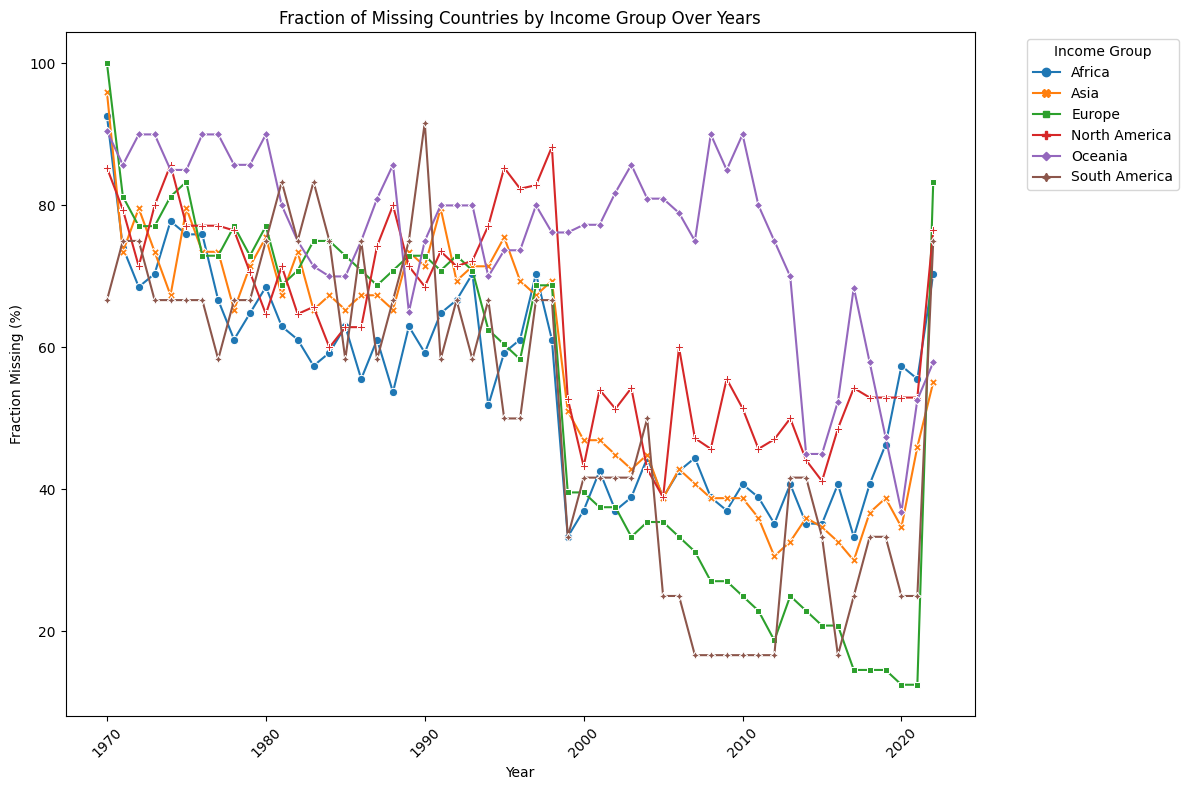

In [299]:
# Assuming your DataFrame is named df
plt.figure(figsize=(12, 8))

# Plot each income group's fraction_missing over the years
sns.lineplot(data=region_missing, x='year', y='fraction_missing', hue='income_group', style='income_group', markers=True, dashes=False)

plt.title('Fraction of Missing Countries by Income Group Over Years')
plt.xlabel('Year')
plt.ylabel('Fraction Missing (%)')
plt.legend(title='Income Group', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust the layout to make room for the legend
plt.show()

In [286]:

# Group by country and year, count non-null values for the indicator
data_availability = tb_data.pivot_table(index=['country', "income_group", "region"], columns='year', values='se_prm_uner', aggfunc=lambda x: x.notnull().sum())

# Replace NaNs with 0 (no data available)
data_availability = data_availability.fillna(0)

# Filter years where at least one country has a non zero value
valid_years = data_availability.sum() > 0
data_availability = data_availability.loc[:, valid_years]

data_availability['total'] = data_availability.sum(axis=1)
tb_sorted = data_availability.sort_values(by='total', ascending=False).drop('total', axis=1)

def plot_heatmap_for_group(df, filter_value, filter_by='income_group', figsize=(10, 8)):
    # Filter the DataFrame based on the specified group
    filtered_df = df.xs(filter_value, level=filter_by)

    # Plot with a fixed figure size
    plt.figure(figsize=figsize)
    ax = sns.heatmap(filtered_df, cmap='binary', cbar=False)
    plt.title(f'Activity by Year - {filter_value}')
    plt.ylabel('Country')
    plt.xlabel('Year')

    # Improve readability if there are many countries
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()  # Adjust layout to not cut off labels

    plt.show()


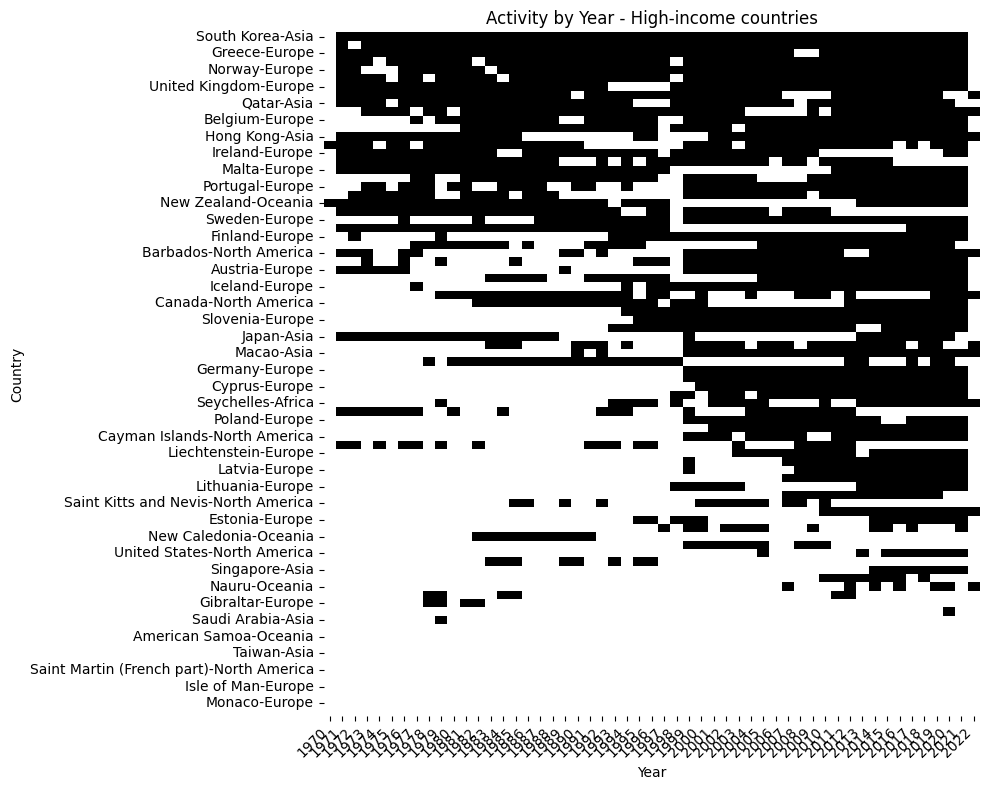

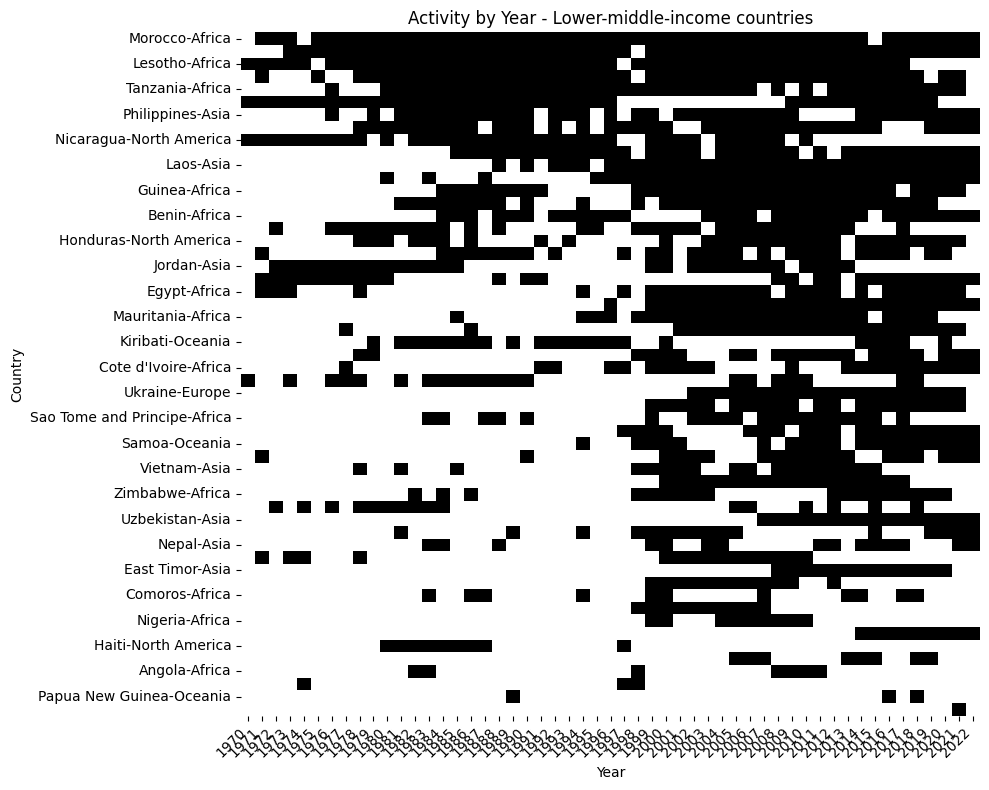

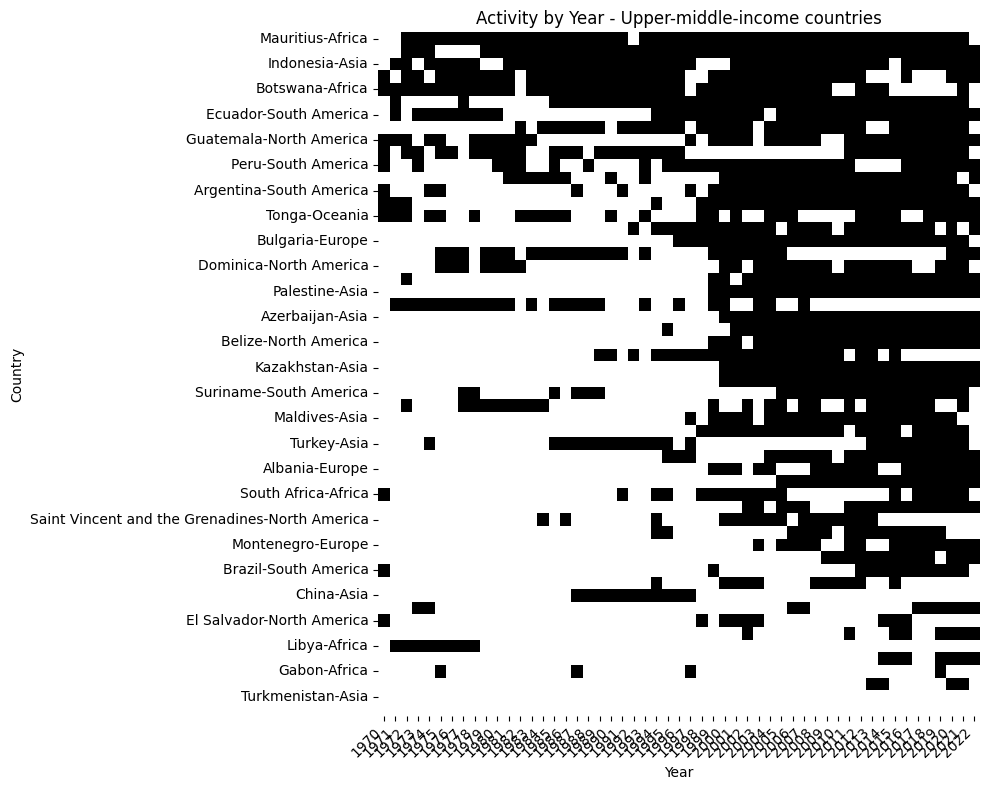

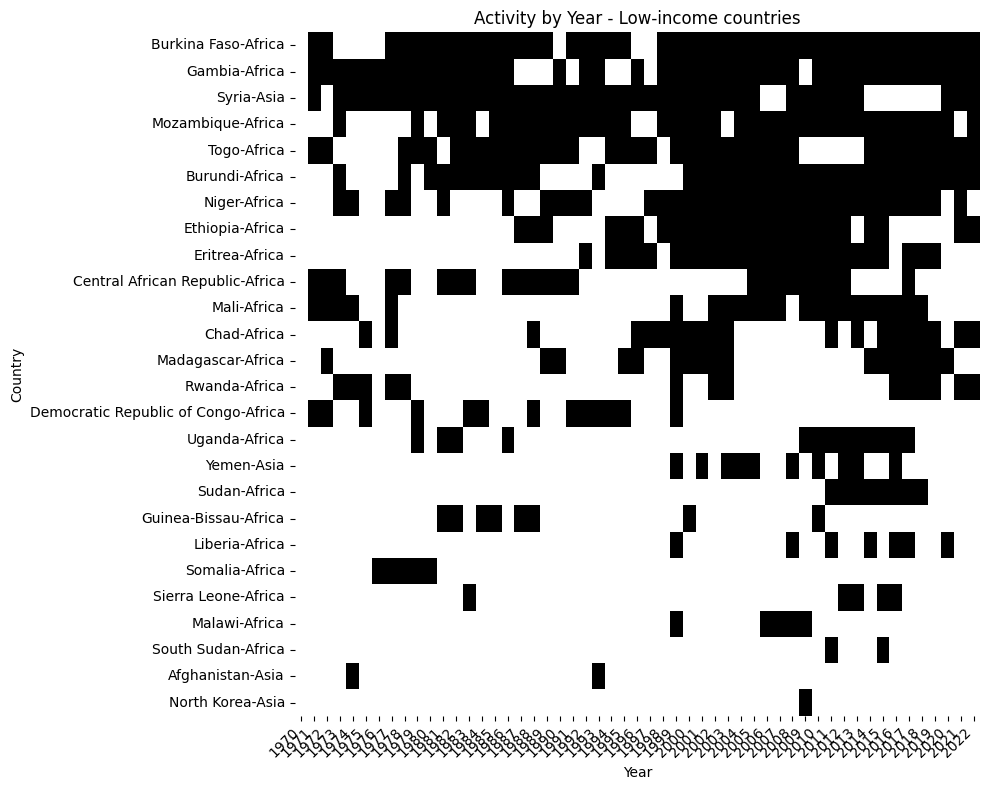

In [287]:
# Example income groups - adjust according to your DataFrame's specific income groups
income_groups = tb_sorted.index.get_level_values('income_group').unique()

for income_group in income_groups:
    plot_heatmap_for_group(tb_sorted, income_group, filter_by='income_group')

In [7]:
ds_who = Dataset(
    DATA_DIR
    / "garden"
    / "who"
    / "2023-08-01"
    / "mortality_database"
)

In [21]:
tb_both = ds_who["neuropsychiatric_conditions__both_sexes__all_ages"].reset_index()
tb_females = ds_who["neuropsychiatric_conditions__females__all_ages"].reset_index()
tb_males = ds_who["neuropsychiatric_conditions__males__all_ages"].reset_index()

filtered_columns = tb_males.filter(items=['country', 'year'] + [col for col in tb_males if col.startswith('deaths_from_neuropsychiatric_conditions_per_100_000_people')])


In [22]:
filtered_columns

,country,year,deaths_from_neuropsychiatric_conditions_per_100_000_people_in__males_aged_all_ages
0,Albania,1987,12.750916
1,Albania,1988,12.561104
2,Albania,1989,15.505769
3,Albania,1992,16.170641
4,Albania,1993,22.220804
...,...,...,...
4794,Venezuela,2015,9.349160
4795,South Africa,2018,20.603548
4796,South Africa,2017,19.874517
4797,South Africa,2016,19.801186


In [23]:
tb_males

,country,year,total_deaths_that_are_from_neuropsychiatric_conditions__in_males_aged_all_ages,share_of_total_deaths_in_males_aged_all_ages_years_that_are_from_neuropsychiatric_conditions,age_standardized_deaths_that_are_from_neuropsychiatric_conditions_per_100_000_people__in_males_aged_all_ages,deaths_from_neuropsychiatric_conditions_per_100_000_people_in__males_aged_all_ages
0,Albania,1987,202,2.096306,18.984844,12.750916
1,Albania,1988,203,2.100362,17.761524,12.561104
2,Albania,1989,254,2.489220,20.773529,15.505769
3,Albania,1992,257,2.585253,20.446520,16.170641
4,Albania,1993,348,3.614083,27.361454,22.220804
...,...,...,...,...,...,...
4794,Venezuela,2015,1398,1.383953,11.502978,9.349160
4795,South Africa,2018,5871,2.461191,31.867355,20.603548
4796,South Africa,2017,5589,2.304286,32.060917,19.874517
4797,South Africa,2016,5492,2.208612,32.692566,19.801186
